In [1]:
import openfermionpyscf as ofpyscf
import openfermion as of
import cirq
import openfermioncirq as ofc
import numpy as np
import pyscf
from openfermion.transforms import get_fermion_operator, jordan_wigner, bravyi_kitaev

In [2]:
diatomic_bond_length = .7414
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., diatomic_bond_length))]
basis = 'sto-3g'
multiplicity = 1
charge = 0
description = str(diatomic_bond_length)

In [3]:
from openfermion.hamiltonians import MolecularData
molecule = MolecularData(geometry, basis, multiplicity, charge)
h2_molecule = ofpyscf.run_pyscf(molecule, run_mp2=True, run_cisd=True, run_ccsd=True, run_fci=True)
elektron=h2_molecule.n_electrons
orbitals = h2_molecule.n_orbitals
qubit= h2_molecule.n_qubits

In [4]:
#Membuat Sirkuit Ansatz /Fungsi Gelombang Coba 
class Ansatz(ofc.VariationalAnsatz):
    def params(self):      
        return [cirq.Symbol('theta_0')]
    def operations(self, qubits):    
        q0, q1,q2,q3= qubits
        yield cirq.XPowGate(exponent=1.5707963267948966).on(q0)
        yield cirq.H(q2)
        yield cirq.CNOT(q0,q2)
        yield cirq.ZPowGate(exponent=cirq.Symbol('theta_0')).on(q2)
        yield cirq.CNOT(q0,q2)
        yield cirq.XPowGate(exponent=-1.5707963267948966).on(q0)
        yield cirq.H(q2)
        
        
        
        
        
        
        
    def _generate_qubits(set):
        return cirq.LineQubit.range(4)

In [5]:
FungsiCoba=Ansatz()
print(FungsiCoba.circuit)

0: ───X^(-3/7)───@───────────────@───X^(3/7)───
                 │               │
2: ───H──────────X───Z^theta_0───X───H─────────


In [6]:
from openfermion.hamiltonians import MolecularData

# Set parameters to make a simple molecule.
diatomic_bond_length = .7414
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., diatomic_bond_length))]
basis = 'sto-3g'
multiplicity = 1
charge = 0
description = str(diatomic_bond_length)

In [7]:
bond_length_interval = 0.1
n_points = 25

CCSD=. -0.6018037168042082
Nilai optimum: -0.6013839176511854
CCSD=. -0.9141497080889696
Nilai optimum: -0.9136190055852353
CCSD=. -1.05515979649697
Nilai optimum: -1.0544783819321277
CCSD=. -1.1162860078288028
Nilai optimum: -1.115406621972759
CCSD=. -1.1361894542843936
Nilai optimum: -1.1350557408844852
CCSD=. -1.1341476664304937
Nilai optimum: -1.1326928096366158
CCSD=. -1.120560280971827
Nilai optimum: -1.1187046094893762
CCSD=. -1.101150330871435
Nilai optimum: -1.0987981855126996
CCSD=. -1.0791929438391945
Nilai optimum: -1.0762310495366445
CCSD=. -1.0567407449167354
Nilai optimum: -1.0530404556904907
CCSD=. -1.0351862642484724
Nilai optimum: -1.0306109703289963
CCSD=. -1.0154682441838383
Nilai optimum: -1.0098855789312784
CCSD=. -0.9981493526444732
Nilai optimum: -0.9914463207719473
CCSD=. -0.9834727288833649
Nilai optimum: -0.97557047537063
CCSD=. -0.9714266897613956
Nilai optimum: -0.9622909544363648
CCSD=. -0.9618169564719969
Nilai optimum: -0.9514612881763577
CCSD=. -0.95433

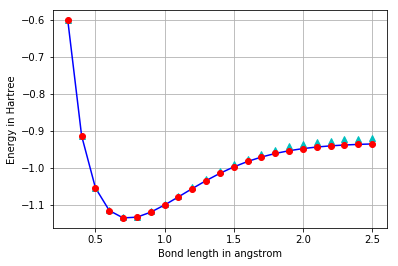

In [9]:
ccsd_energies = []
fci_energies=[]
vqe_uccsd_energies = []
bond_lengths = []
for point in range(3, n_points + 1):
    bond_length = bond_length_interval * point
    bond_lengths += [bond_length]
    description = str(round(bond_length,2))
    #print("Jarak Antar Atom=",description)
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    molecule1 = MolecularData(
        geometry, basis, multiplicity, description=description)
    molecule1.load()
    hamiltonian = ofpyscf.generate_molecular_hamiltonian(geometry, basis, multiplicity, charge)
    #print(hamiltonian)
    hamiltonan_bk=bravyi_kitaev(get_fermion_operator(hamiltonian))
    #print("H_JW=",hamiltonan_jw)
    #mendeklarasikan Hamiltonan yang akan ditinjau
    objektif = ofc.HamiltonianObjective(hamiltonan_bk)

    #membuat keadaan referensi
    q0, q1, _, _ = FungsiCoba.qubits
    keadaan_refensi = cirq.Circuit.from_ops(cirq.X(q0))


    study = ofc.VariationalStudy(name='VQE BK Small Hydrogen',ansatz=FungsiCoba,objective=objektif,preparation_circuit=keadaan_refensi)
    #optimasi
    algoritma = ofc.optimization.ScipyOptimizationAlgorithm(kwargs={'method': 'nelder-mead'},options={'maxiter': 100})


    optimization_params = ofc.optimization.OptimizationParams(algorithm=algoritma,initial_guess=FungsiCoba.default_initial_params())
    result = study.optimize(optimization_params)
    print("CCSD=.",molecule1.ccsd_energy)
    print('Nilai optimum: {}'.format(result.optimal_value))
    #print("parameter optimasinya:")
    #print(result.optimal_parameters)
    ccsd_energies += [molecule1.ccsd_energy]
    fci_energies += [molecule1.fci_energy]
    vqe_uccsd_energies += [result.optimal_value]
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(0)
plt.plot(bond_lengths, ccsd_energies, 'b-')
plt.plot(bond_lengths, vqe_uccsd_energies, 'c^')
plt.plot(bond_lengths, fci_energies,'ro')
plt.grid()
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.show()